In [2]:
import pandas as pd 
import sys
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.metrics import roc_auc_score, roc_curve
import scipy.stats as stats
import pickle
import numpy as np
from scipy.stats import wilcoxon, spearmanr, pearsonr

sys.path.append("C:/Users/20182460/Documents/GitHub/THESIS/analysis_kather")
sys.path.append("C:/Users/20182460/Documents/GitHub/THESIS/IF_analysis")
from kather_analysis_function import AUC_kather
from IF_analysis_function import IF_scoring
from sklearn.linear_model import LinearRegression
from concurrent.futures import ProcessPoolExecutor

In [2]:
pred_dir_no_norm_MSE = "C:/Users/20182460/Desktop/Master_thesis/Code/Outputs/FINAL RESULTS/CRC/MIL/MIL_loss_norm_tests/simple_nn_no_norm_MSE/all_cell_types.csv"
pred_dir_no_norm_cor = "C:/Users/20182460/Desktop/Master_thesis/Code/Outputs/FINAL RESULTS/CRC/MIL/MIL_loss_norm_tests/simple_nn_no_norm_cor/all_cell_types.csv"
pred_dir_norm_MSE = "C:/Users/20182460/Desktop/Master_thesis/Code/Outputs/FINAL RESULTS/CRC/MIL/MIL_loss_norm_tests/simple_nn_norm_MSE/all_cell_types.csv"
pred_dir_norm_cor = "C:/Users/20182460/Desktop/Master_thesis/Code/Outputs/FINAL RESULTS/CRC/MIL/MIL_loss_norm_tests/simple_nn_norm_cor/all_cell_types.csv"

pred_no_norm_MSE = pd.read_csv(pred_dir_no_norm_MSE, sep=",")
pred_no_norm_cor = pd.read_csv(pred_dir_no_norm_cor, sep=",")
pred_norm_MSE = pd.read_csv(pred_dir_norm_MSE, sep=",")
pred_norm_cor = pd.read_csv(pred_dir_norm_cor, sep=",")

print(pred_no_norm_MSE.columns)


Index(['tile_ID', 'tumor_purity', 'slide_id', 'Coord_X', 'Coord_Y', 'T_cells'], dtype='object')


In [ ]:
test_names = ['no_norm_MSE', 'no_norm_cor', 'norm_MSE', 'norm_cor']
predictions = [pred_no_norm_MSE, pred_no_norm_cor, pred_norm_MSE, pred_norm_cor]

kather_results = {}

# Loop over each method
for test_name, pred in zip(test_names, predictions):
    
    AUC_tumor, significance_tumor, all_probs_pos, all_probs_neg = AUC_kather(pred, 'T_cells', 'LYM')
    
    # Combine positive and negative probabilities and calculate AUC
    combined_labels = [1] * len(all_probs_pos) + [0] * len(all_probs_neg)
    combined_probs = all_probs_pos + all_probs_neg
    auc_combined = roc_auc_score(combined_labels, combined_probs)
    print(f'{test_name}: {auc_combined}')
    
    # Save results in the dictionary
    kather_results[test_name] = [AUC_tumor, significance_tumor, auc_combined]

output_dir = "C:/Users/20182460/Desktop/Master_thesis/Code/Outputs/FINAL RESULTS/CRC/MIL/MIL_loss_norm_tests"
with open(f'{output_dir}/kather_results_norm_loss_T_cells.pkl', 'wb') as f:
    pickle.dump(kather_results, f)


Finished kather analysis
no_norm_MSE: 0.4056709475247244
Finished kather analysis
no_norm_cor: 0.740530140020509
Finished kather analysis
norm_MSE: 0.6481452233746305
Finished kather analysis
norm_cor: 0.7533644394796143


In [4]:
output_dir_kather = "C:/Users/20182460/Desktop/Master_thesis/Code/Outputs/FINAL RESULTS/CRC/MIL/MIL_loss_norm_tests"

with open(f"{output_dir_kather}/kather_results_norm_loss_T_cells.pkl", 'rb') as f:
    kather_results_T = pickle.load(f)
with open(f"{output_dir_kather}/kather_results_norm_loss_tumor.pkl", 'rb') as f:
    kather_results_tumor = pickle.load(f)

test_names = ['no_norm_MSE', 'no_norm_cor', 'norm_MSE', 'norm_cor']

slide_score_list = kather_results_tumor['no_norm_MSE'][0]
AUCs = slide_score_list.values()

# Iterate over the test names and collect the values from both dictionaries
for test_name in test_names:
    slide_score_list = kather_results_T[test_name][0]  # Value from kather_results_T
    AUCs = slide_score_list.values()  # Get all values
    average_AUC = sum(AUCs)/len(AUCs)
    print(f"{test_name}: {average_AUC:.4f}")

no_norm_MSE: 0.4304
no_norm_cor: 0.6538
norm_MSE: 0.5823
norm_cor: 0.6522


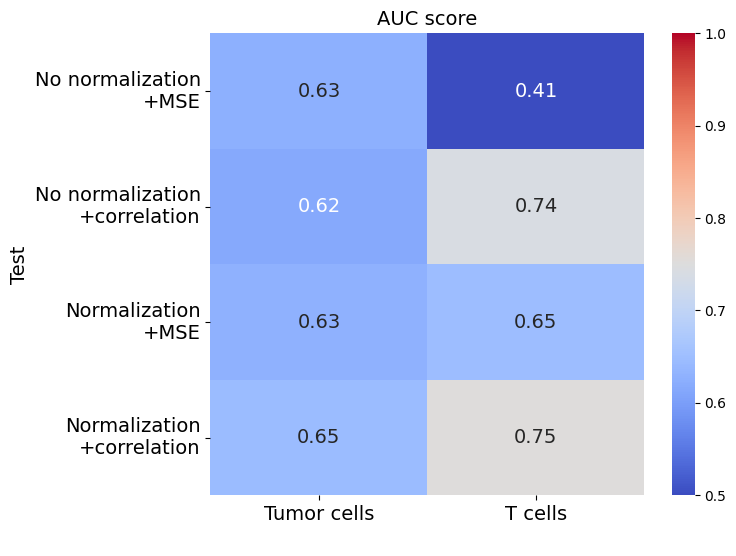

In [26]:
output_dir_kather = "C:/Users/20182460/Desktop/Master_thesis/Code/Outputs/FINAL RESULTS/CRC/MIL/MIL_loss_norm_tests"

with open(f"{output_dir_kather}/kather_results_norm_loss_T_cells.pkl", 'rb') as f:
    kather_results_T = pickle.load(f)
with open(f"{output_dir_kather}/kather_results_norm_loss_tumor.pkl", 'rb') as f:
    kather_results_tumor = pickle.load(f)

test_names = ['no_norm_MSE', 'no_norm_cor', 'norm_MSE', 'norm_cor']

# Create a matrix to store values
heatmap_values = []

# Iterate over the test names and collect the values from both dictionaries
for test_name in test_names:
    # Collect values from both kather_results_T and kather_results_tumor for the current test_name
    row = [
        kather_results_tumor[test_name][2],  # Value from kather_results_T
        kather_results_T[test_name][2]  # Value from kather_results_tumor
    ]
    # Append the row of values to the heatmap_values list
    heatmap_values.append(row)

# Convert the list of values into a NumPy array for better handling
heatmap_values = np.array(heatmap_values)

test_names_new = ['No normalization\n+MSE', 'No normalization\n+correlation', 'Normalization\n+MSE', 'Normalization\n+correlation']
# Create a heatmap using seaborn
plt.figure(figsize=(7, 6))  # Set the size of the figure
sns.heatmap(heatmap_values, annot=True, cmap='coolwarm', xticklabels=['Tumor cells\n', 'T cells\n'], yticklabels=test_names_new, 
            cbar=True, vmin=0.5, vmax=1, fmt=".2f", annot_kws={'size': 14})

# Add titles and labels
plt.title('AUC score', fontsize=14)  # Larger title
plt.ylabel('Test', fontsize=14)  # Larger y-label

# Increase fontsize for tick labels
plt.xticks(rotation=0, fontsize=14)
plt.yticks(fontsize=14, rotation=0)

output_dir_norm_loss = "C:/Users/20182460/Desktop/Master_thesis/Figures report/norm_loss"
plt.savefig(f"{output_dir_norm_loss}/AUC_scores.png", dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


In [ ]:
output_dir = "C:/Users/20182460/Desktop/Master_thesis/Code/Outputs/FINAL RESULTS/CRC/MIL/MIL_loss_norm_tests/IF_results"

test_names = ['no_norm_MSE', 'no_norm_cor', 'norm_MSE', 'norm_cor']
predictions = [pred_no_norm_MSE, pred_no_norm_cor, pred_norm_MSE, pred_norm_cor]

double_marker = True
marker1 = 'E-cadherin' 
marker2 = 'Pan-CK'
cell_type = "tumor_purity"
file_name = "EpiT_double"

percentile = 99
remove_empty_tiles = True
num_bins = 100
min_tile_count = 1
# Loop over each method
for test_name, pred in zip(test_names, predictions):
    # Compute IF scores
    all_results = IF_scoring(pred, percentile, double_marker, marker1, marker2, cell_type, remove_empty_tiles, num_bins, min_tile_count)

    with open(f'{output_dir}/{test_name}_{file_name}', 'wb') as f:
        pickle.dump(all_results, f)


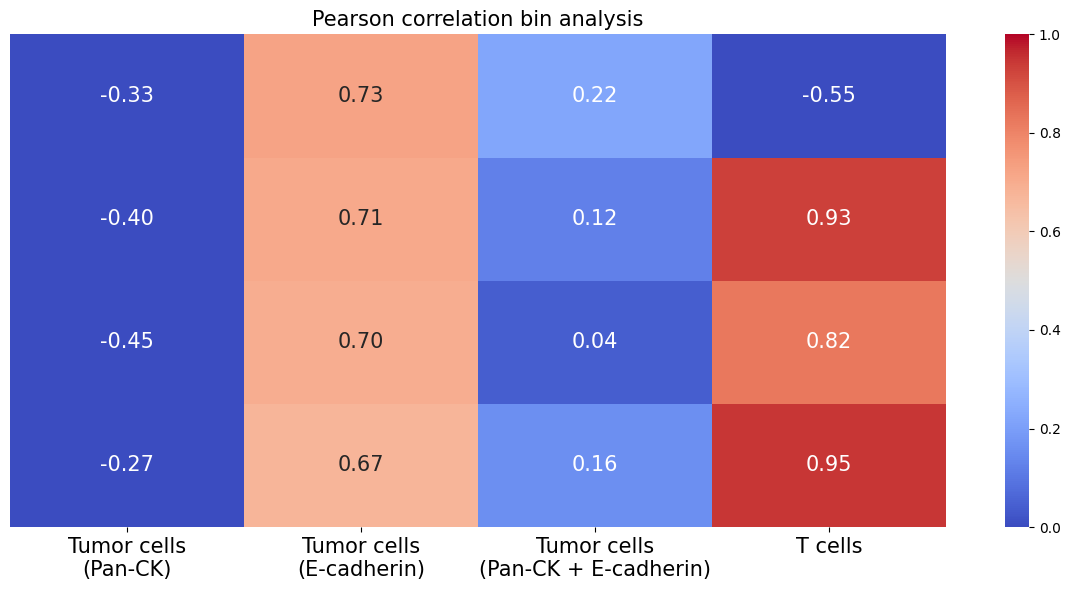

In [30]:
test_names = ['no_norm_MSE', 'no_norm_cor', 'norm_MSE', 'norm_cor']
cell_types = ['Tumor cells\n(Pan-CK)', 'Tumor cells\n(E-cadherin)', 'Tumor cells\n(Pan-CK + E-cadherin)', 'T cells']  # X-axis labels

tumor_r_double  = [0.2223, 0.1232, 0.0399, 0.1596]
tumor_r_E_cadherin = [0.7259, 0.7074, 0.6965, 0.6745]
tumor_r_panck = [-0.3303, -0.3956, -0.4491, -0.2736]
tumor_r_T = [-0.5458, 0.9321, 0.8245, 0.9477]

# Combine scores into a 2D array
data = np.array([tumor_r_panck, tumor_r_E_cadherin, tumor_r_double, tumor_r_T]).T  # Transpose the array

# Create the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(data, annot=True, fmt=".2f", cmap="coolwarm", xticklabels=cell_types, 
            yticklabels=test_names, cbar=True, vmin=0, vmax=1, annot_kws={'size': 15})


plt.title("Pearson correlation bin analysis", fontsize=15)

# Increase fontsize for tick labels
plt.xticks(rotation=0, fontsize=15)
plt.yticks([])

# Show the heatmap
plt.tight_layout()

output_dir_norm_loss = "C:/Users/20182460/Desktop/Master_thesis/Figures report/norm_loss"
plt.savefig(f"{output_dir_norm_loss}/pearson_correlations_tiles.png", dpi=300, bbox_inches='tight')


plt.show()


In [20]:
loaded_data = {}
IF_dir = "C:/Users/20182460/Desktop/Master_thesis/Code/Outputs/FINAL RESULTS/CRC/MIL/MIL_loss_norm_tests/IF_results"
test_names = ['no_norm_MSE', 'no_norm_cor', 'norm_MSE', 'norm_cor']
markers = ['CD3e', 'tumor_double', 'E-cadherin']

for test_name in test_names:
    for marker in markers:
        with open(f"{output_dir}/{test_name}_{marker}.pkl", "rb") as file:
            loaded_data[f"{test_name}_{marker}"] = pickle.load(file)

print(loaded_data)
print(loaded_data['no_norm_MSE_tumor_double'])

{'no_norm_MSE_CD3e': None, 'no_norm_MSE_tumor_double': None, 'no_norm_MSE_E-cadherin': None, 'no_norm_cor_CD3e': None, 'no_norm_cor_tumor_double': None, 'no_norm_cor_E-cadherin': None, 'norm_MSE_CD3e': None, 'norm_MSE_tumor_double': None, 'norm_MSE_E-cadherin': None, 'norm_cor_CD3e': None, 'norm_cor_tumor_double': None, 'norm_cor_E-cadherin': None}
None


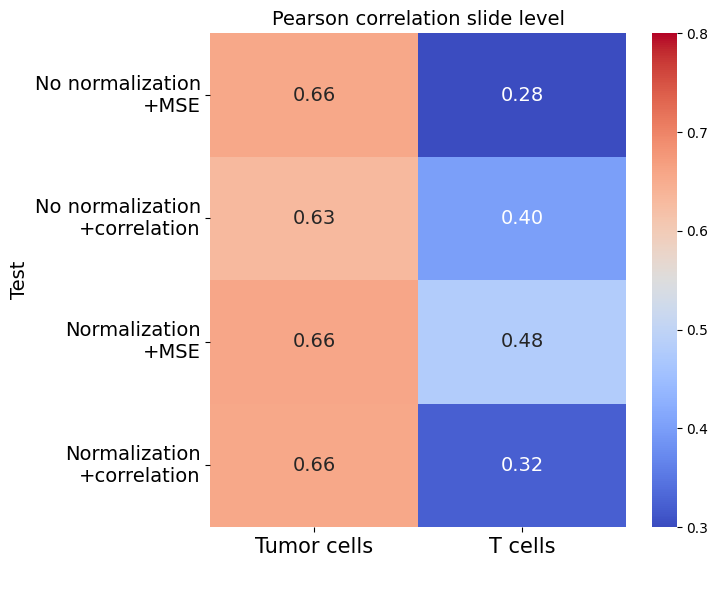

In [24]:
test_names = ['no_norm_MSE', 'no_norm_cor', 'norm_MSE', 'norm_cor']
cell_types = ['Tumor cells\n', 'T cells\n']  # X-axis labels

tumor_slide_scores = [0.6569, 0.6311, 0.6582, 0.6560]
t_slide_scores = [0.2752, 0.4006, 0.4779, 0.3215]

# Combine scores into a 2D array
data = np.array([tumor_slide_scores, t_slide_scores]).T  # Transpose the array

# Create the heatmap
plt.figure(figsize=(7.5, 6))
test_names_new = ['No normalization\n+MSE', 'No normalization\n+correlation', 'Normalization\n+MSE', 'Normalization\n+correlation']
sns.heatmap(data, annot=True, fmt=".2f", cmap="coolwarm", xticklabels=cell_types, yticklabels=test_names_new, vmin=0.3, vmax=0.8, 
            annot_kws={'size': 14})

# Add labels and title
plt.ylabel("Test", fontsize=14)
plt.xticks(rotation=0, fontsize=15)
plt.yticks(fontsize=14)  
plt.title("Pearson correlation slide level", fontsize=14)

# Show the heatmap
plt.tight_layout()

output_dir_norm_loss = "C:/Users/20182460/Desktop/Master_thesis/Figures report/norm_loss"
plt.savefig(f"{output_dir_norm_loss}/pearson_correlations_slide.png", dpi=300, bbox_inches='tight')

plt.show()

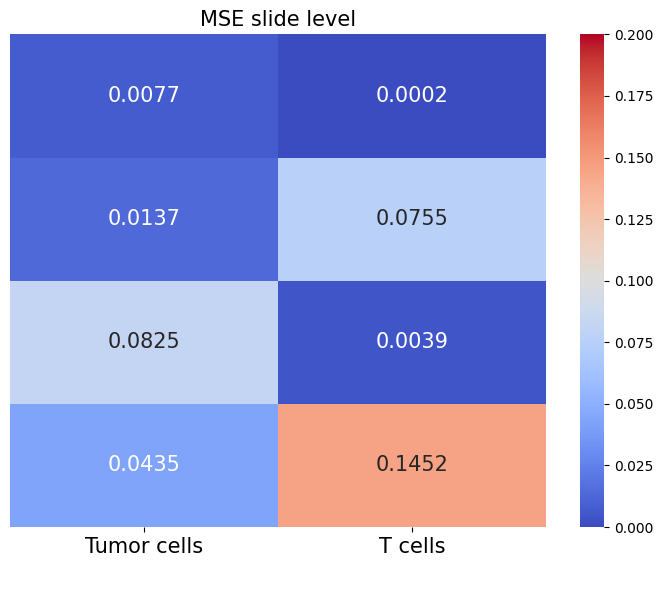

In [28]:
test_names = ['no_norm_MSE', 'no_norm_cor', 'norm_MSE', 'norm_cor']
cell_types = ['Tumor cells\n', 'T cells\n']  # X-axis labels

MSE_tumor = [0.00769, 0.01372, 0.08253, 0.04349]
MSE_T = [0.00019, 0.07547, 0.00392, 0.14515]

# Combine scores into a 2D array
data = np.array([MSE_tumor, MSE_T]).T  # Transpose the array

# Create the heatmap
plt.figure(figsize=(7, 6))
sns.heatmap(data, annot=True, fmt=".4f", cmap="coolwarm", xticklabels=cell_types, yticklabels=test_names, vmin=0, vmax=0.2,
            annot_kws={'size': 15})

# Add labels and title
#plt.xlabel("Cell Types")
#plt.ylabel("Test")
plt.title("MSE slide level", fontsize=15)

plt.yticks([])  
plt.xticks(rotation=0, fontsize=15)
plt.tight_layout()

output_dir_norm_loss = "C:/Users/20182460/Desktop/Master_thesis/Figures report/norm_loss"
plt.savefig(f"{output_dir_norm_loss}/MSE_slide.png", dpi=300, bbox_inches='tight')


plt.show()